In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import cv2
from PIL import Image

In [2]:
from typing import Union, Optional, Dict
from torch import Tensor

class ImageDataset(Dataset):
    def __init__(self,
                 csv_path,
                 transform,
                 augment = None):
        
        self.img_csv = pd.read_csv(csv_path)
        self.transform = transform
        self.augment = augment

    def __getitem__(self, index: int) -> Dict[str, Union[Tensor, int]]:
        image_record = self.img_csv.iloc[index]
        image = self.get_preprocessed_image(image_record.path)
        
        return image

    def __len__(self) -> int:
        return self.img_csv.shape[0]

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(path)[..., ::-1]

        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        return image

    def preprocess_image(self, image: np.ndarray) -> Tensor:
        if self.augment is not None:
            image = self.augment(image=image)['image']

        image_tensor = self.transform(Image.fromarray(image))

        return image_tensor

    def get_preprocessed_image(self, path: str) -> Tensor:
        image = self.read_image(path)
        image_tensor = self.preprocess_image(image)

        return image_tensor

In [3]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
train_dataset = ImageDataset('train.csv', transform)
test_dataset = ImageDataset('test.csv', transform)

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, num_workers=0)

valid_dataloader = DataLoader(test_dataset, batch_size=16,
                        shuffle=True, num_workers=0)

In [6]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
#         self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),
            nn.Sigmoid()
        )
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)
#         x = F.relu(self.t_conv1(x))
#         x = F.sigmoid(self.t_conv2(x))
        embedding = self.encoder(x)
        return self.decoder(embedding)


#Instantiate the model
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [7]:
#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [9]:
#Epochs
n_epochs = 40

train_losses = []
valid_losses = []

for epoch in tqdm(range(1, n_epochs+1)):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in tqdm(train_dataloader):
        images = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_dataloader)
    train_losses.append(train_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    
    # monitor valid loss
    valid_loss = 0.0

    #Validation
    for data in valid_dataloader:
        images = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        valid_loss += loss.item()*images.size(0)
    
    valid_loss = valid_loss/len(valid_dataloader)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tValid Loss: {:.6f}'.format(epoch, valid_loss))


Epoch: 1 	Training Loss: 10.686077
Epoch: 1 	Valid Loss: 4.254253



Epoch: 2 	Training Loss: 8.610384
Epoch: 2 	Valid Loss: 4.056599



Epoch: 3 	Training Loss: 8.455486
Epoch: 3 	Valid Loss: 4.015767



Epoch: 4 	Training Loss: 8.389878
Epoch: 4 	Valid Loss: 3.983999



Epoch: 5 	Training Loss: 8.336622
Epoch: 5 	Valid Loss: 3.964053



Epoch: 6 	Training Loss: 8.296674
Epoch: 6 	Valid Loss: 3.948298



Epoch: 7 	Training Loss: 8.269885
Epoch: 7 	Valid Loss: 3.936404



Epoch: 8 	Training Loss: 8.250832
Epoch: 8 	Valid Loss: 3.929311


KeyboardInterrupt: 

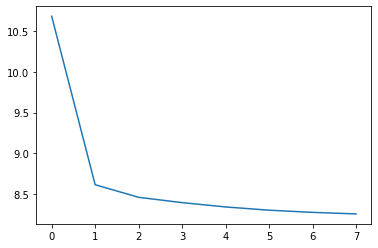

In [10]:
plt.plot(train_losses)

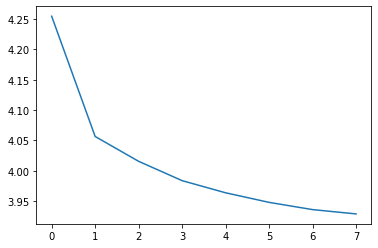

In [11]:
plt.plot(valid_losses)

In [12]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [13]:
def plot_batch(batch, batch_size):
    assert batch_size % 4 == 0
    side = batch_size // 4
    fig = plt.figure(figsize=(8, 8))
    # display 20 images
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(side, side, idx+1, xticks=[], yticks=[])
        imshow(batch[idx])

In [91]:
def plot_batch_numpy(batch, batch_size):
    assert batch_size % 4 == 0
    side = batch_size // 4
    fig = plt.figure(figsize=(8, 8))
    # display 20 images
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(side, side, idx+1, xticks=[], yticks=[])
        plt.imshow(batch[idx])

In [14]:
#Obtain one batch of training images
dataiter = iter(valid_dataloader)

In [15]:
images = dataiter.next()

In [16]:
output = model(images.cuda())

In [17]:
output = output.view(16, 3, 28, 28)
output = output.cpu().detach().numpy()

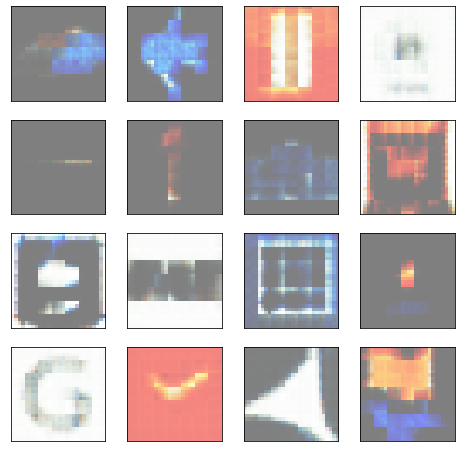

In [18]:
plot_batch(output, 16)

In [19]:
images = images.numpy() # convert images to numpy for display

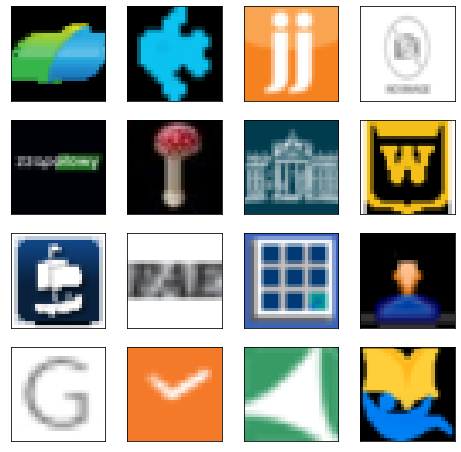

In [20]:
plot_batch(images, 16)

In [95]:
class Embedder(nn.Module):
    def __init__(self):
        super(Embedder, self).__init__()
        self.embedder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
    def forward(self, x):
        embed = self.embedder(x)
        
        bs = embed.size()[0]
        
        return embed.view(bs, -1)

In [96]:
embedder = Embedder()
embedder.embedder = model.encoder

In [105]:
torch.save(embedder.state_dict(), 'embedder.pth')

In [23]:
embeddings = []

In [24]:
for tensor in tqdm(train_dataset):
    out = embedder(tensor.unsqueeze(0).cuda()).numpy()
    embeddings.append(out)

In [28]:
embeddings = np.array(embeddings)

In [31]:
embeddings = np.array([emb.squeeze(0) for emb in embeddings])

In [37]:
embeddings = np.array([emb.cpu().detach().numpy() for emb in embeddings])

In [38]:
embeddings.shape

(40695, 196)

In [106]:
np.save("embeddings.npy", embeddings)

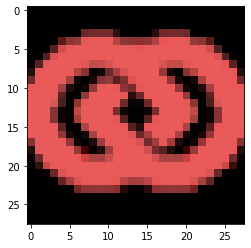

In [43]:
imshow(test_dataset[0])

In [97]:
test = test_dataset[6].unsqueeze(0)

In [79]:
class Index:
    def __init__(self, embeddings):
        self.embeddings = embeddings
    
    def rank(self, embedding, top_k=16):
        dists = self.calc_dists(embedding)
        order = np.argsort(dists)
        
        return order[:top_k], dists[order][:top_k]
    
    def calc_dists(self, embedding):
        dists = self.embeddings - embedding
        dists = np.linalg.norm(dists, axis=1)
        
        return dists

In [80]:
index = Index(embeddings)

In [98]:
embedding = embedder(test.cuda()).cpu().detach().numpy()

In [99]:
ids, dists = index.rank(embedding)

In [86]:
train_data = pd.read_csv('train.csv')

In [100]:
top_paths = [train_data.path[iid] for iid in ids]

In [101]:
top_imgs = [cv2.imread(path)[..., ::-1] for path in top_paths]

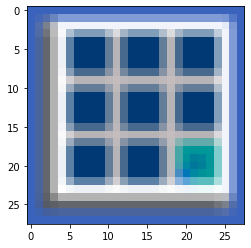

In [103]:
imshow(test_dataset[6])

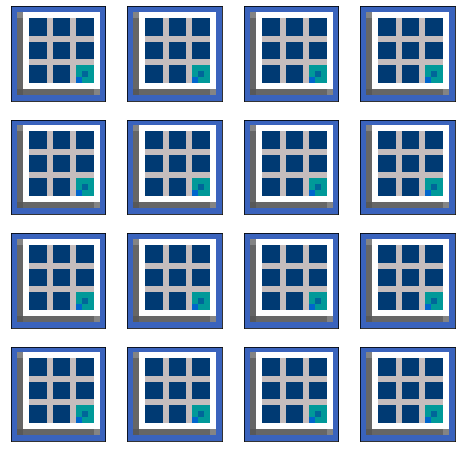

In [104]:
plot_batch_numpy(top_imgs, 16)